# Inputs to DALI Dataset with External Source

In this tutorial we will show how to use external data inputs with `DALIDataset`. The following sections demonstrate how to provide `DALIDataset` with data from other [TensorFlow tf.data.Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) as well as how to use DALI [Exernal Source operator](../../../operations/nvidia.dali.fn.external_source.html) with custom Python code to generate the data.

This tutorial assumes, that you are familar with DALIDataset API - a way of running DALI Pipeline as `tf.data.Dataset` compatible object. You can find more in tutorials about [using pipelines in DALIDataset with tf.data](tensorflow-dataset.ipynb) and [running DALIDataset on multiple GPUs](tensorflow-dataset-multigpu.ipynb). 

## Inputs from Other tf.data.Datasets

DALI already offers a set of dedicated [reader operators](../../../operations/nvidia.dali.fn.readers.html), as well as allows to specify custom Python code as a data source in the pipeline via [External Source](../../../operations/nvidia.dali.fn.external_source.html) operator.

DALI Pipeline wrapped into TensorFlow-compatible Dataset object can take other `tf.data.Dataset` objects as inputs, allowing you to use DALI to process the inputs created with TensorFlow API

*Note: Inputs to DALIDataset are in experimental phase now, and the API can be adjusted in the future versions of DALI.*

*Note: The use of inputs is currently enabled by the additional variant of DALIDataset, available in DALI Tensorflow Plugin as `experimental.DALIDatasetWithInputs`.*

In the following paragraphs we will demonstrate how one can specify those inputs and indicate their place in DALI pipeline.


### Selecting Input Dataset
As an example we will use [tf.data.TFRecordReader](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset), even though DALI has its own, native variant. 
We will use an example dataset from [DALI_extra](https://github.com/NVIDIA/DALI_extra) - DALI test data repository. We will extract the encoded images from that TFRecord dataset and pass them to DALI for decoding.

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

### Tensorflow Dataset

First, we prepare the TensorFlow `Dataset` using the `tf.data` API. We need to provide the data path to the `TFRecordDataset` constructor.

Next, we select the encoded image as the feature that we want to extract and parse using the `tf.io.parse_single_example` with the `schema` we defined. We also convert the raw `tf.string` tensor into a typed numeric one using `tf.io.decode_raw` - which can be consumed by DALI. 

The last two steps will comprise our `decode_fn` that we will map over the `TFRecordDataset`. We defined our `input_dataset`.

In [1]:
import tensorflow as tf

tf.compat.v1.enable_eager_execution()
import os

# Path to TFRecord dataset
data_path = os.path.join(os.environ["DALI_EXTRA_PATH"], "db/tfrecord/train/")

# We want to extract the encoded images
images_key = "image/encoded"

# Schema for raw, encoded buffers
schema = {images_key: tf.io.FixedLenFeature([], tf.string, "")}


def decode_fn(record_bytes):
    parsed_examples = tf.io.parse_single_example(record_bytes, schema)
    encoded_image = tf.io.decode_raw(parsed_examples[images_key], tf.uint8)
    return encoded_image


input_dataset = tf.data.TFRecordDataset(data_path).map(decode_fn)

### DALI Pipeline

Now we need to define a DALI Pipeline that can accept `tf.data.Dataset` as the input and decode the buffers provided by that input. 

We use `external_source` operator node with a specific `name` argument as placeholder node for inputs from Tensorflow. In this example we will use one input but there can be more, as long as the placeholder `fn.external_source` nodes have unique names.

In [2]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

batch_size = 2


@pipeline_def(device_id=0, num_threads=4, batch_size=batch_size)
def pipeline_with_inputs(device):
    encoded = fn.external_source(name="input_from_tf_record", dtype=types.UINT8)
    images = fn.decoders.image(
        encoded, device="mixed" if device == "gpu" else "cpu"
    )
    resized = fn.resize(images, size=(300, 500))
    return resized

Notice that our pipeline can be parametrized with the `device` so we can accelerate decoding on GPU. We will need to take special care of DALIDataset and inputs placement when we use GPU acceleration. 

We also resize all the images to the same size, as TensorFlow expects data batches to be uniform.

### Constructing DALIDataset

Now let's import the experimental `DALIDatasetWithInputs`. It differs from the `DALIDataset` by adding additional `input_datasets` argument, to which we pass a dictionary that maps names of `external_source` nodes to input `tf.data.Dataset` objects.

Here it is pretty simple, as we have only one `input_dataset` that we want to map to `'input_from_tf_record'`, we will name it `input_spec_dict`.
 
For the first example we use the CPU placement.

In [3]:
import nvidia.dali.plugin.tf as dali_tf

input_spec_dict = {"input_from_tf_record": input_dataset}

pipe = pipeline_with_inputs("cpu")

with tf.device("/cpu:0"):
    dali_dataset = dali_tf.experimental.DALIDatasetWithInputs(
        pipeline=pipe,
        input_datasets=input_spec_dict,
        batch_size=batch_size,
        output_shapes=None,
        output_dtypes=tf.uint8,
        device_id=0,
    )

### Collecting the Results

Since we started in eager mode, we can run our DALIDataset in a regular loop, convert the results to NumPy and visialize them.

In [4]:
def run(dali_dataset, iters=2):
    result = []
    for batch, i in zip(dali_dataset, range(iters)):
        images = batch[0].numpy()
        for sample_idx in range(batch_size):
            result.append(images[sample_idx])
    return result

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math


def display(outputs, columns=2, captions=None, cpu=False):
    rows = int(math.ceil(len(outputs) / columns))
    fig = plt.figure()
    fig.set_size_inches(16, 6 * rows)
    gs = gridspec.GridSpec(rows, columns)
    row = 0
    col = 0
    for i in range(len(outputs)):
        plt.subplot(gs[i])
        plt.axis("off")
        if captions is not None:
            plt.title(captions[i])
        plt.imshow(outputs[i])

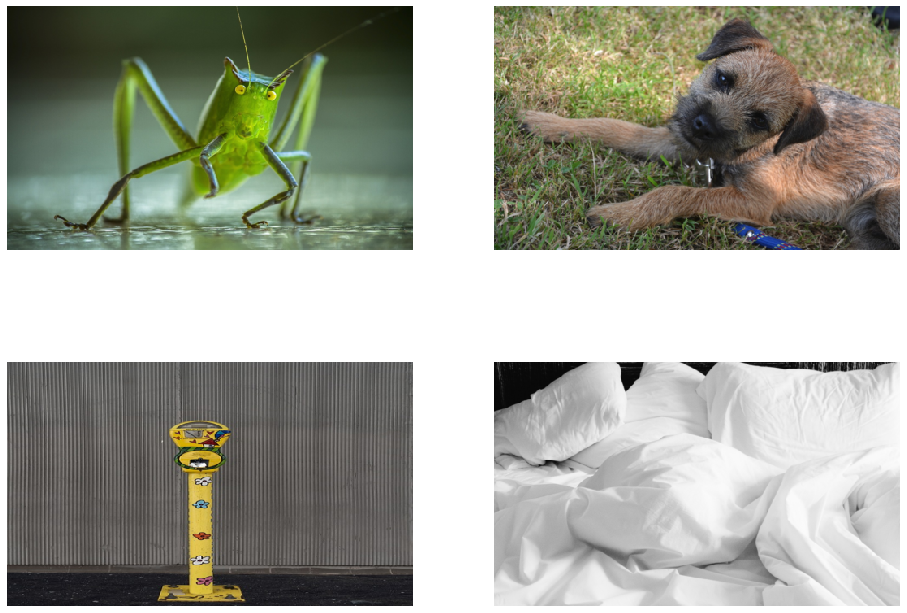

In [6]:
display(run(dali_dataset))

## Batch and Per-sample Mode

There are few additional things to consider. TensorFlow Datasets operates on "Examples" - which usually are single, dense Tensors. Even if we applied `.batch(batch_size)` to some `tf.data.Dataset`, the resulting values would be tensors, with the outermost dimension equal to `batch_size`. 

DALI by design operates on batches of data. While providing the input from TensorFlow to DALI, we can specify whether that particular `external_source` node should query its input for batches or separate samples. In the latter case, DALI will query the input `batch_size` times to build a batch - there is no need to do it manually.

Passing a `tf.data.Dataset` via the `input_datasets` parameter of `DALIDatasetWithInputs` automatically indicates, that this input should be treated as per-sample.

To show that DALIDataset can handle multiple inputs in different modes, we will create an additional dataset input, this time running in batch mode.

### Generator Dataset

We use a simple generator with a generator dataset, to return a numpy array that gets progresively more red. Next, we use the Batch dataset, to showcase how we can specify batch data sources from TensorFlow to DALI.

We also highlight the fact, that the Generator Dataset can only be placed on the CPU.

In [7]:
import numpy as np


def get_red():
    current_red = 64
    max_red = 255
    while True:
        yield np.full((300, 500, 3), (current_red, 0, 0), dtype=np.float32)
        current_red = min(current_red + 1, max_red)


signature = tf.TensorSpec(shape=(300, 500, 3), dtype=tf.float32)

with tf.device("/cpu:0"):
    batch_dataset = tf.data.Dataset.from_generator(
        get_red, output_signature=signature
    ).batch(batch_size)

### Pipeline with Two Inputs

Now, let's adjust the pipeline by adding the second `external_source` placeholder node to represent second input, and using it for some processing.

In [8]:
import nvidia.dali.math as dmath
import nvidia.dali.types as types


@pipeline_def(device_id=0, num_threads=4, batch_size=batch_size)
def pipeline_with_two_inputs(device):
    encoded = fn.external_source(name="input_from_tf_record", dtype=types.UINT8)
    red = fn.external_source(name="input_from_generator", dtype=types.FLOAT)
    if device == "gpu":
        red = red.gpu()
    images = fn.decoders.image(
        encoded, device="mixed" if device == "gpu" else "cpu"
    )
    resized = fn.resize(images, size=(300, 500))
    saturated_red = dmath.min(resized + red, 255.0)
    return fn.cast(saturated_red, dtype=types.UINT8)

### Specifying Batched Input

To notify DALI that we pass an input representing a batch, we need to pass some additional opionts alongside that input. For this particular case we can use `nvidia.dal.plugin.tf.experimental.Input`.

The `Input` class takes several arguments: `tf.data.Dataset` input for which we want to pass options, as well as `layout` and `batch` that can override arguments present in `external_source` node defintion - providing `None` for any of them will make DALI use the one defined in DALI pipeline. We will set `batch=True` to select batch mode. Also, we can specify `'HWC'` layout to DALI. 

Let's update our example by extending the `input_datasets` dictionary specification.

In [9]:
two_inputs_spec_dict = {
    "input_from_tf_record": input_dataset,
    "input_from_generator": dali_tf.experimental.Input(
        batch_dataset, batch=True, layout="HWC"
    ),
}

pipe_batched_input = pipeline_with_two_inputs("cpu")

with tf.device("/cpu:0"):
    batched_dali_dataset = dali_tf.experimental.DALIDatasetWithInputs(
        pipeline=pipe_batched_input,
        input_datasets=two_inputs_spec_dict,
        batch_size=batch_size,
        output_shapes=None,
        output_dtypes=tf.uint8,
        device_id=0,
    )

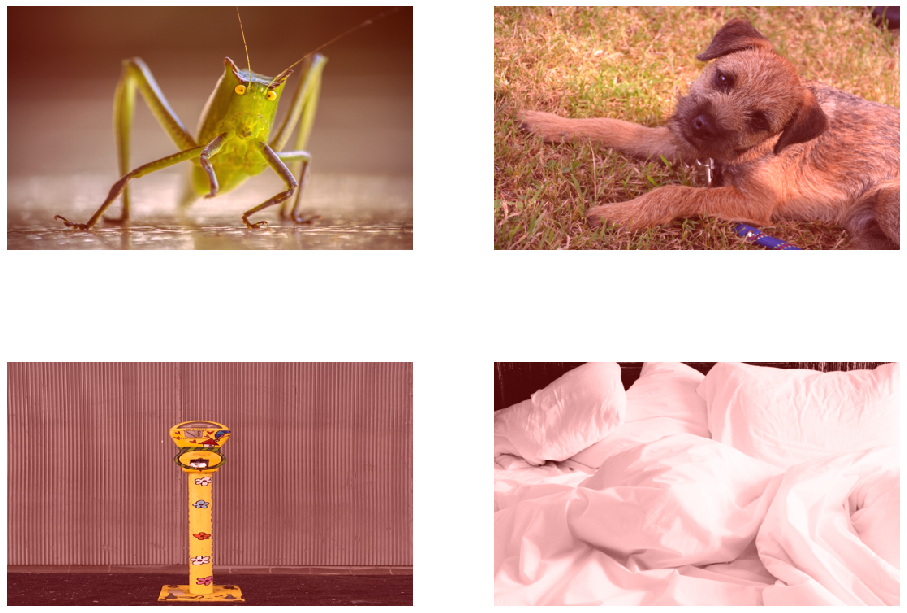

In [10]:
display(run(batched_dali_dataset))

Alternatively, for the `'input_from_generator'`, we could use `Input` class with `batch=None` and pass `batch=True` to the `fn.external_source` with that name in Pipeline definition, making it `fn.external_source(name='input_from_generator', batch=True)`. Note that if an option is provided to `Input` class as `None` it is taken from the Pipeline defintion.

## GPU Placement

If you want to benefit from DALI potential fully, you need to utilize the GPU acceleration. Both of the example pipelines that we prepared can be used with GPU acceleration, but they need some adjustment.

First, they need to be placed on GPU. We also need to adjust our inputs - TensorFlow requires that every input to a GPU-placed is also available on GPU. Most of the `tf.data.Dataset` cannot be placed directly on GPU - this is also true for the input datasets that we constructed. Thus we need to be manually transer the input datasets to the GPU we placed `DALIDataset` on using [tf.data.experimental.copy_to_device](https://www.tensorflow.org/api_docs/python/tf/data/experimental/copy_to_device).

Bewere, that GPU-placed DALIDataset should be the last dataset and should not be processed by other `tf.data.Dataset` classes.

### Explcit Copy

Let start with transfering the input datasets to `/gpu:0`. Next we use them to specify a new dictionary for `input_datasets` parameter. At last we take a new instance of DALI pipeline, this time specified for `'gpu'` acceleration and wrap it into GPU-placed DALIDatasetWithInputs.

In [11]:
input_dataset_gpu = input_dataset.apply(
    tf.data.experimental.copy_to_device("/gpu:0")
)
batch_dataset_gpu = batch_dataset.apply(
    tf.data.experimental.copy_to_device("/gpu:0")
)


two_inputs_spec_dict_gpu = {
    "input_from_tf_record": input_dataset_gpu,
    "input_from_generator": dali_tf.experimental.Input(
        batch_dataset_gpu, batch=True, layout="HWC"
    ),
}

pipe_gpu = pipeline_with_two_inputs("gpu")

with tf.device("/gpu:0"):
    dali_dataset_gpu = dali_tf.experimental.DALIDatasetWithInputs(
        pipeline=pipe_gpu,
        input_datasets=two_inputs_spec_dict_gpu,
        batch_size=batch_size,
        output_shapes=None,
        output_dtypes=tf.uint8,
        device_id=0,
    )

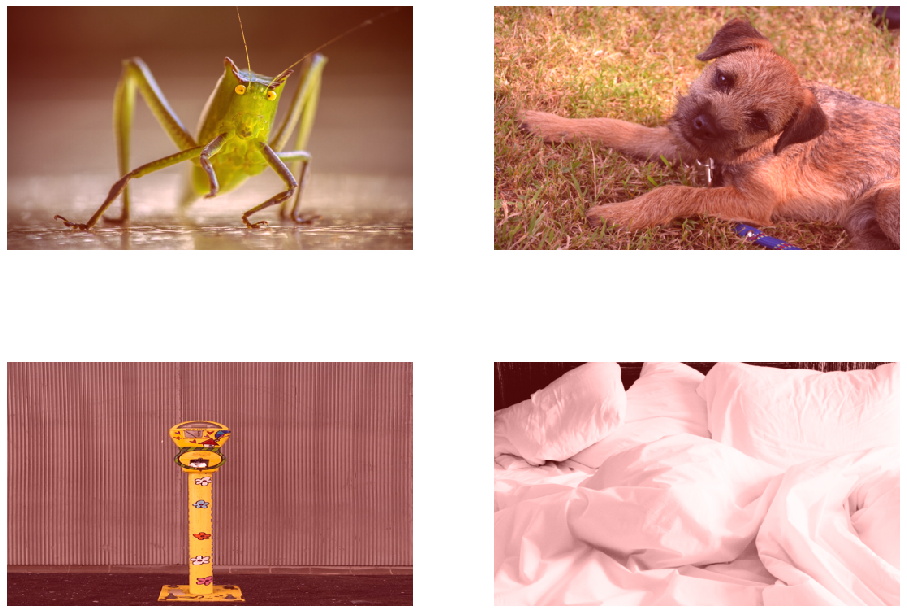

In [12]:
display(run(dali_dataset_gpu))

## Handling of External Source `source` Parameter

In the previous examples, we used TensorFlow's Generator Dataset (`tf.data.Dataset.from_generator()`). DALI has similar functionality baked into External Source operator - one can pass Python code: a callback or iterable through the `source` parameter. You may even have some pipelines already defined this way, that you have used with other Deep Learning Frameworks.

`DALIDatasetWithInputs` allows to run Pipelines, that have External Source nodes with `source` parameters without additional changes.

It automatically detects the placement of the `DALIDataset` and translates the `source` into a TensorFlow Generator Dataset placed on CPU. Some of the [restrictions](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) may apply, but it supports all kinds of `source` parameters that DALI supports:

* callables
* iterables
* generator functions

in both batch and per-sample mode.

This integration works only with Python `source` returning CPU data. 

### Example of `source` Handling

Let's start with the second pipeline that we defined. This time instead of manually providing the NumPy arrays with red channel from TensorFlow via `input_datasets`, we will put the generator function directly into DALI pipeline.

We keep the first input dataset, to show, that we can mix those two methods.

We set `batch=False` in the second `external_source`, as the generator is defined as returning separate samples.

In [13]:
@pipeline_def(device_id=0, num_threads=4, batch_size=batch_size)
def pipeline_with_source(device):
    encoded = fn.external_source(name="input_from_tf_record", dtype=types.UINT8)
    # Now we don't need to name this node, we just pass the `source`
    red = fn.external_source(source=get_red, batch=False, dtype=types.FLOAT)
    if device == "gpu":
        red = red.gpu()
    images = fn.decoders.image(
        encoded, device="mixed" if device == "gpu" else "cpu"
    )
    resized = fn.resize(images, size=(300, 500))
    saturated_red = dmath.min(resized + red, 255.0)
    return fn.cast(saturated_red, dtype=types.UINT8)

Now we don't need to pass any additional details in `input_datasets` to handle the `fn.external_source(source=get_red)` - it will be done automatically.

In [14]:
inputs_spec_dict_gpu = {
    "input_from_tf_record": input_dataset_gpu,
}

pipe_source_gpu = pipeline_with_source("gpu")

with tf.device("/gpu:0"):
    dali_dataset_source = dali_tf.experimental.DALIDatasetWithInputs(
        pipeline=pipe_source_gpu,
        input_datasets=inputs_spec_dict_gpu,
        batch_size=batch_size,
        output_shapes=None,
        output_dtypes=tf.uint8,
        device_id=0,
    )

Let's run the example.

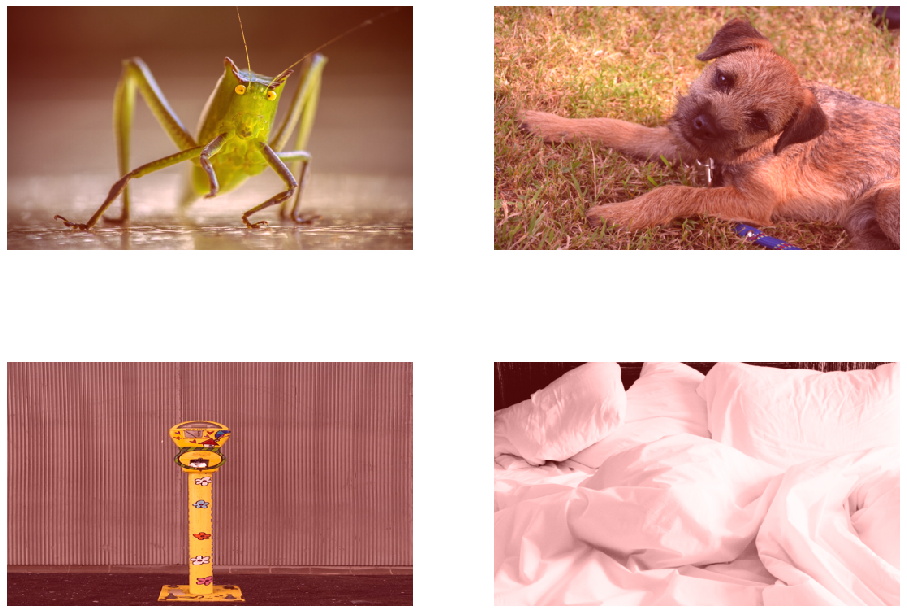

In [15]:
display(run(dali_dataset_source))

### Limitations

Due to current TensorFlow limitations, when using GPU-placed DALIDataset, the inputs will be delivered as GPU memory - after the mandatory `copy_to_device`. When used with External Source with CPU device: `fn.external_source(device='cpu')` there will be an additional GPU to CPU copy inside DALI. One can also use `device='gpu'`, removing the copy.